<h1 align="center"> Trends in Technological Advancements </h1>
<div style="float: left">Gautam Arakalgud (garakalg)</div>
<div style="float: right">Sampath Chanda (schanda)</div>
<div style="margin: 0 auto; width: 200px;">Praneet Dutta (praneetd)</div>

### Introduction

Academic papers, patents and trademarks are often a very good indication of the direction in which a field of research is evolving. In this project, we aim to procure and analyze millions of patents, published academic work and trademarks. The procured documents must range over a wide period of time (~20 years) and over diverse fields in order give us a sense of how academic research has evolved over time and how inter and cross disciplinary research has grown.

**Dataset:**
- The US Patent and Trademark Office has made all its patent and trademark information freely available for public use. The database consists of 9.4 million records from 1981 to present. We procure and analyze the titles of these patents for relevant information.
- For published work, we used the arxiv database. We obtained metadata for all arxiv submissions through the Open Archives Initiative (OAI). We processed ~100,000 abstracts and titles and analyzed them.

**Project Accomplishments:**
- Identify key areas of research in specific years by building a bag of words (TF/TFIDF) model. We pick up scientific key words and map them to areas of research.
- Identify key trends in the development of specific fields of research (eg. Advances in Deep Learning). We select a single field of research and visualize publication trends specific to that field over the years.
- Develop a Latent Drichlet Allocation model for the entirety of the absract data and identify 100 distinct topics and coresponding key words. This is an unsupervised approach to identifying fields of research from the data.
- As a fun experiment we generate a new abstract from the N-gram model that we develop from the entire abstract data.

### Related Work

Our research closely follows that of Hoonlor et. al. [1]. They build language models on pubication data within Computer Science obtained from 1990-2010 from the ACM and IEEE explore digital libraries. They developed a TFIDF bag of words model for the data as well as a 'Bursty Period and Trend Analysis'. They also plot graphs of research trends against time.

### Import Statements

In [1]:
%matplotlib inline
import scipy.sparse as sp
import numpy as np 
import sklearn.preprocessing as sk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import collections
stop_list=stopwords.words('english')
from tfidf_and_cosine import cosine_similarity
import operator
import pickle
import pdngram
from pdngram import LanguageModel
import ExtractArchive1
from ExtractArchive1 import extractp
import math
import gzip, glob, re
from sklearn.feature_extraction import text
import string
import os
import pandas as pd

<h2>Data Collection</h2>

### Google Scholar

Google scholar is a publicly available and freely accesible search engine for scholarly literature. Here we try to obtain publication data from Google Scholar by developing a querier and parser for Google Scholar output. Although there are [open source parsers](https://github.com/ckreibich/scholar.py) that do this, it is easier to write a customized parser that parses the information we need. It's classes can be invoked independently or used as a command line tool. Currently the parser implements the full functionality of Scholar's *Advanced Search* option and recursively retrieves the titles of the search outputs. Since Google does not provide the complete abstract in its output, there is no way simple way to parse the complete abstract for all results. The following code run from the command line parses the first 1000 results for a particular query and dumps them into a .pkl file.

In [ ]:
!./scholared.py -A "deep learning" --after 2005 --before 2010

The above line of code executed by the shell, parses all results for the search phrase "deep learning" published between the dates 2005 and 2010 and dumps them into a pkl file. This allows us to use this data later for further analysis.

### ArXiv

Although Google Scholar allowed us to implement an advanced search and retrieve specific results, it had limitations in that it provides only the first 1000 results, which is not a lot from a Big Data perspective. Secondly only the titles of publications can be scraped in a standardized way.
ArXiv helped us overcome these limitations. Archive publishes metadata for all its publications under the [Open Archives Initiative](https://arxiv.org/help/oa/index). We use [this script](https://github.com/dfm/data.arxiv.io/blob/master/scrape.py) to scrape metadata from the ArXiv. The metadata includes the ID, Category, Abstract and Title. One such record is listed below.

In this project we restrict our analysis to publications within Computer Science from arXiv.

In [6]:
with gzip.open('data/cs/2016-12-02.txt.gz', 'r') as f:
    record = f.readline()
    Id, cat, title, abstract = record.split('\t')
    print "ID: {}".format(Id)
    print "Category: {}".format(cat)
    print "Title: {}".format(title)
    print "Abstract: {}".format(abstract)

ID: 1612.00570
Category: cs.SY
Title: Application of Microgrids in Supporting Distribution Grid Flexibility
Abstract: Distributed renewable energy resources have attracted significant attention in recent years due to the falling cost of the renewable energy technology , extensive federal and state incentives , and the application in improving load-point reliability . This growing proliferation , however , is changing the traditional consumption load curves by adding considerable levels of variability and further challenging the electricity supply-demand balance . In this paper , the application of microgrids in effectively capturing the distribution network net load variability , caused primarily by the prosumers , is investigated . Microgrids provide a viable and localized solution to this challenge while removing the need for costly investments by the electric utility on reinforcing the existing electricity infrastructure . A flexibility-oriented microgrid optimal scheduling model is

<h3>USPTO Bulk data</h3>

The US Patent and Trademark Office has made all its patent and trademark information freely available for public use. This data can be found <a href='https://pairbulkdata.uspto.gov/'>here</a>. The database consists of 9.4 million records from 1981 to present. This data is available in XML and JSON formats out of which, we chose to work with data in JSON format owing to ease of working with JSON structures. Currently, we are extracting the titles of each of the patent out of the year wise bulk data of patents. Following code extracts titles of patents from json data of patents information. Since the extraction of titles from huge json files is very time consuming, we are dumping the list of titles into pickle files so as to be able to load the data whenever required.

The data must be downloaded into the folder 'DataCollection' before the code below can be run.

In [9]:
import sys
sys.path.insert(0, 'DataCollection/')

from DataCollection import dataCollection, loadPickle

# Extract titles of all patents of the 2016 year
# Takes 2016.json and dumps into 2016.pkl
dataCollection('DataCollection/2016.json')

Let us load the pickle file generated above into a list.

In [10]:
titlesList = loadPickle('DataCollection/2016.pkl')
print [str(title) for title in titlesList[0:25]] # Printing first 25 titles

['ROSACEA TREATMENTS AND KITS FOR PERFORMING THEM', 'MINI-OPTICAL NETWORK TERMINAL (ONT)', 'CHARGE EQUALIZATION SYSTEM FOR BATTERIES', 'ELECTROMECHANICAL TRANSDUCER COMPRISING A POLYURETHANE POLYMER WITH POLYESTER AND/OR POLYCARBONATE UNITS', 'High-Pressure Side Separation of Liquid Lubricant for Lubricating Volumetrically Working Expansion Machines', 'SUBCUTANEOUS INSERTER DEVICE', 'Pesticide Compositions Containing Thyme Oil and Cinnamon Oil', 'Nanostructured Mn-Al Permanent Magnets And Method of Producing Same', 'METHOD OF MANUFACTURING ALUMINA-BASED MILLING MEDIUM', 'PEPTIDES FOR USE IN THE TREATMENT OF IL-1 RELATED DISEASES AND CONDITIONS', 'Light with a film for altering the radiation characteristics', 'SOLE MEMBER OF FOOTWEAR', 'TAPELINE AND BLOCKING MEMBER FOR TAPELINE END', 'STEAM IRON', 'PNEUMATIC TIRE', 'Solder Ball Supplying Method, Solder Ball Supplying Device, and Solder Bump Forming Method', 'INFORMATION PROCESSING DEVICE, INFORMATION PROCESSING METHOD, INFORMATION PROCE

With a quick glance, we can see that the titles of patent data aren't representative or characteristic of the field of research that they belong to.

<h3> Patent Data Analysis </h3>

Once the titles have been collected, we aim to make some sense of it. We import the data from the pickle file which is stored in our local directory. We import the NLTK Stop Word List and remove blank spaces as well from each title. After this, we build a bag of words model from the title data. Our TFIDF function returns a sparse TFIDF matrix, a list of unique words and a doctionary of word counts.

In [15]:
# TFIDF referenced from assignment solutions

from tfidf_and_cosine import tfidf
number_of_docs=5000
x=titlesList[1:number_of_docs]
x=[xx.encode('UTF8') for xx in x]

#####STOP WORD REMOVAL START########################

test_1=[]
for sentence in x:
    sentence=sentence.lower()
    text = ' '.join([word for word in sentence.split() if word not in (stopwords.words('english'))])
    test_1.append(text)
    
##############STOP WORD REMOVAL END############################

sparse_mat, word_list, dict_words = tfidf(x)

<h4> Similarity analysis </h4>

We attempt to clean the data and derive similiarties among documents using the Cosine Similarity function,and see which documents  are the most correlated with each other. We identify the document that is most similar to every document (by comparing titles) after setting the diagonal elements to zero. We proceed to list all of these documents and the Histogram of similarities is plotted below. We also attempt to list out the document title that is similar to most other documents in an attemp to identify a trending research field. The results, albeit interesting, are not accurate because we're working with document titles only.

 [('AMINO-ALCOHOL', 8283), ('Situ', 8282), ('Bacteria', 8281), ('Site', 8280), ('SELF', 8279), ('INCREASED', 8278), ('Surface-modified', 8277), ('OXAZOLE', 8276), ('LOCAL', 8275), ('VALUABLE', 8274), ('INSECT', 8273), ('GEARED', 8272), ('SPACE', 8271), ('BALLS', 8270), ('Procedures', 8269)]
41
Document which is Most Similar to all is: SCAN DRIVING CIRCUIT


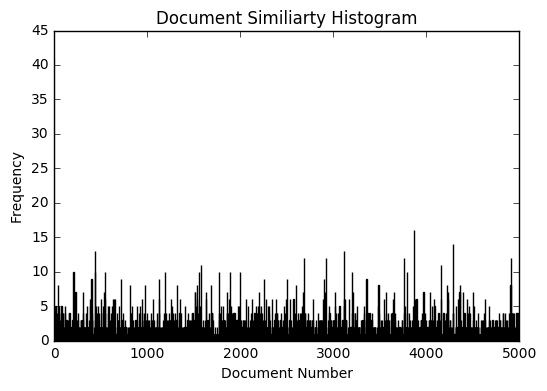

In [28]:
numWords = 15

top = sorted(dict_words.items(), key=operator.itemgetter(1))
top_n = top[len(top) - numWords:]
top_n = top_n[::-1]
print top_n 

###########GETTING MOST SIMILAR DOCUMENTS############
doc_sim=cosine_similarity(sparse_mat)  
M,N=(doc_sim).shape
a = np.ones((M, M), int)
np.fill_diagonal(a, 0)
Cosine_List=np.multiply(doc_sim,a)

Highest_Sim = np.argmax(Cosine_List,axis=1)
Highest_Sim = [x[0] for x in Highest_Sim.tolist()]
simCount = collections.Counter(Highest_Sim)

High = simCount.most_common()[0][1]

print "Document which is Most Similar to all is:", titlesList[High]
plt.hist(Highest_Sim,M)
plt.title("Document Similiarty Histogram")
plt.xlabel("Document Number")
plt.ylabel("Frequency")

###############PLOTTING THEM#####################

From a simple similarity analysis of the 2016 patent data, we can get a brief idea of the trending fields of research and discovery in 2016. Bio-chemical research seems to be the most prominent field of research today!

However, as mentioned earlier, analysis based on title data only may be deceiving and not accurate. Hence, following this short analysis, we move to analyzing publications by their abstracts.

## ArXiv Data Analysis

We start by collecting all the Arxiv metadata into a pandas dataframe. We apply a little pre-processing that includes removing NaN and processing the category field to include the first and ignore the rest. We also convert the string categories into discrete labels for a later stage.

In [33]:
def importData(files):
    arxivData = pd.DataFrame(columns=['ID', 'Category', 'Title', 'Abstract'])
    for file in files:
        df = pd.read_csv(file, sep='\t', header=None, names=['ID', 'Category', 'Title', 'Abstract'])
        arxivData = arxivData.append(df, ignore_index=True)
    arxivData = arxivData[pd.notnull(arxivData['Abstract'])]
    for ind, cat in enumerate(arxivData['Category']):
        arxivData['Category'][ind] = cat.split()[0]
    categoryDict = {}
    categories = list(set(arxivData['Category']))
    for ind, cat in enumerate(categories):
        categoryDict[cat] = ind
    labels = [None]*arxivData.shape[0]
    labels = [categoryDict[arxivData['Category'].iloc[i]] for i in xrange(arxivData.shape[0])]
    arxivData['Labels'] = labels

    return arxivData


arxivFile = 'arxivData.pkl'
if os.path.isfile(arxivFile):
    arxivData = pd.read_pickle(arxivFile)
else:
    arxivData = importData(sys.argv[1:])
    arxivData.to_pickle('arxivData.pkl')
print "Data Read"

Data Read


#### TF and TFIDF generation

We use the sklearn library to generate the TF and TFIDF matrices for the abstract data, where each document represents a separate record. Along with a bag of words model, we also generate TFIDF scores for N-grams of 1-3 words. As before, we separate out the stop words from the data.

In [34]:
from sklearn.feature_extraction import text
def tfGen(arxivData):
    tf = text.TfidfVectorizer(use_idf=False, analyzer='word', ngram_range=(1, 3), stop_words='english')
    abstractTf = tf.fit_transform(arxivData['Abstract'])

    print "TF marix generated"
    return (tf, abstractTf)

def tfidfGen(arxivData):
    tfidf = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 3), stop_words='english')
    abstractTfidf = tfidf.fit_transform(arxivData['Abstract'])

    print "TFIDF matrix generated"
    return (tfidf, abstractTfidf)

tfidf, abstractTfidf = tfidfGen(arxivData)

TFIDF matrix generated


#### Document Analysis and Key word generation

We begin our analysis by picking out 100 random documents (abstracts) from the curpus. We obtain the words/n-grams corresponding to the top 10 TFIDF scores for each document and display them. We expect that these are key words that *define* the abstract. We also obtain the words corresponding to the top TFIDF scores across all the documents. The words with the top TFIDF scores (as expected) are common words such as paper, propose, results, etc that we would likely see in any abstract. We therefore pick the words in the range of 150-200 in a list sorted by the TFIDF scores to give us a better representation. Can we see a pattern?

In [69]:
import random
def docAnalysis(tfidf, abstractTfidf):
    abstractFeatures = tfidf.get_feature_names()

    docs = random.sample(xrange(abstractTfidf.shape[0]), 100)
    print "Writing TFIDF scores to file"
    with open('AbstractAnalysis', 'w') as fd:
        for doc in docs: 
            feature_index = abstractTfidf[doc,:].nonzero()[1]
            tfidf_scores = zip(feature_index, [abstractTfidf[doc, x] for x in feature_index])
            tfidf_scores = sorted(tfidf_scores, key=operator.itemgetter(1))

            for word, score in [(abstractFeatures[i], score) for (i, score) in tfidf_scores[:10]]:
                fd.write(' ({}, {}) '.format(word, score))
            fd.write('\n')

    tfidfSum = abstractTfidf.sum(axis=0)
    featScore = zip(abstractFeatures, tfidfSum.tolist()[0])
    featScore.sort(key=lambda x: x[1], reverse=True)
    print "Key words:"
    print featScore[150:200]
        
docAnalysis(tfidf, abstractTfidf)

Key words:
[(u'neural', 183.28101467453328), (u'programming', 181.32256040087682), (u'processing', 179.80880390105904), (u'node', 179.44911147016626), (u'representation', 179.07624051966087), (u'dynamic', 178.42165967053091), (u'introduce', 178.36273036484036), (u'experiments', 177.81642685183377), (u'domain', 177.42311221894028), (u'simulation', 176.67341412221862), (u'better', 176.40783664250804), (u'tree', 176.3944912720697), (u'distance', 176.1589167147734), (u'allows', 176.1165543354417), (u'compared', 175.842015273901), (u'implementation', 175.64185961680326), (u'best', 175.25405535236374), (u'obtained', 172.9666382736758), (u'provides', 172.78301764262628), (u'accuracy', 171.75797570711146), (u'complex', 171.006837976417), (u'decision', 170.5978040325364), (u'context', 169.4179501814186), (u'machine', 169.3660051199667), (u'memory', 169.19608340335287), (u'training', 168.8941489659579), (u'main', 168.44294541791388), (u'sparse', 168.34436019415344), (u'maximum', 168.164427147818

We can see words like 'Neural', 'Programming', 'Processing', 'machine', 'training', 'decision', 'game', 'human', 'feature', etc. that point us to machine learning, AI and pattern recognition. This result is expected in today's world that is moving towards automation, learning models, artificial intelligence, etc.

We can also see words like 'node', 'domain', 'mobile', 'web' etc. that are characteristic of mobile computing, the internet, etc which are also ubiquitous.

#### Document Prediction

On a small detour, we conduct an experiment to see how much information the abstract contains about the content of the paper itself. How well is the machine able to classify documents under various categories given a bag of words model of the abstract only. We train a multiclass SVM on a random 80% subset of the arxiv data and test the SVM on the remaining 20% of the data. How well the SVM does is a good measure of how representative the words in the abstract are, of the category itself.

In [48]:
from sklearn.svm import SVC
def categoryPrediction(arxivData, abstractTfidf):
    randPerm = np.random.permutation(arxivData.shape[0])
    lenTrain = len(randPerm)*4/5
    trainInd = randPerm[:lenTrain]
    testInd = randPerm[lenTrain:]

    print "Training SVM"
    classifier = SVC(kernel='rbf')
    classifier.fit(abstractTfidf[trainInd][:], arxivData['Labels'].iloc[trainInd])
    pred = classifier.predict(abstractTfidf[testInd])
    accuracy = float(np.sum(pred == arxivData['Labels'].iloc[testInd]))/len(testInd)
    print "Test accuracy: {}%".format(accuracy*100)
    
categoryPrediction(arxivData.iloc[], abstractTfidf[])

Training SVM
Test accuracy: 40.0%


Arxiv has 40 subcategories for the larger category 'Computer Science'. At a random guess, we would achieve an accuracy of 2.5%. Our trained SVM model achieves a test accuracy of 40%. If this seems a little low, it is likely because
- The dataset is a little skewed and some categories have very few abstracts that belong to them.
- Abstracts are also not completely representative of the field of research that they correspond to.

If we ran this model on a bag of words model of the entire publication, we would have likely seen better results.

### Latent Drichlet Allocation

Latent Drichlet Allocation is an automatic way of classifying an unlabelled set of documents into different categories or topics. It's a clustering algorithm of sorts that makes sense of the textual content of documents from the words that they contain. It divides the documents into k clusters/categories and picks out the key words that are characteristic of these topics along with an associated weight. It is an unsupervised approach to document analysis and making sense of documents. Looking at the different categories in the arxiv data, we can see that there are ~100 different categories that documents could be divided into and hence we obtain keywords for these 100 categories in an unsupervised fashion. The code and implementation is based on [this package](https://github.com/dfm/arxiv-analysis). Before you run the code below -
- Create a directory named abstracts in the arxiv-analysis folder.
- Setup and run a mongodb server on port 27017
- Setup and run redis-server on port 27019

In [ ]:
!python arxiv-analysis/analysis.py scrape abstracts
# scrapes all the metadata from the arXiv OAI interface and saves the raw 
# XML responses as abstracts/raw-*.xml. This takes a long time because of 
# the arXiv's flow control policies. It took me approximately 6 hours.

In [ ]:
!python arxiv-analysis/analysis.py parse abstracts/raw-*.xml
# parses the raw responses and saves the abstracts to a MongoDB database 
# called arxiv in the collection called abstracts.

In [ ]:
!python arxiv-analysis/analysis.py build-vocab
# counts all the words in the corpus removing anything with less than 3 
# characters and removing any stop words.

In [ ]:
!python arxiv-analysis/analysis.py get-vocab 100 5000 > vocab.txt
# lists the vocabulary skipping the first 100 most popular words and 
# keeping 5000 words total.

In [ ]:
!python arxiv-analysis/analysis.py run vocab.txt
# runs online variational LDA by randomly selecting articles from the database.
# The topic distributions are stored in the lambda-*.txt files.
# This will run forever so just kill it whenever you feel like it.

In [56]:
!python arxiv-analysis/analysis.py results vocab.txt lambda-100.txt > arxiv-output.txt
# list the topics and their most common words at step 100

In [71]:
with open('arxiv-output.txt', 'r') as f:
    topics = f.readlines()
for topic in topics[:10]:
    print topic.rstrip()

Displaying results...
Topic 0: stellar (4.0), matrix (2.7), abundances (1.9), brain (1.7), sne (1.6), oxygen (1.5), homology (1.4), metal-poor (1.4), class (1.3), upon (1.3)
Topic 1: qubits (2.9), entanglement (1.1), multipartite (1.0), qubit (0.8), genuine (0.8), noise (0.7), initial (0.7), characterizing (0.6), symmetric (0.6), superconducting (0.5)
Topic 2: operator (3.7), operators (2.8), projection (2.2), helicity (1.3), muons (1.2), degenerate (0.9), analytical (0.9), special (0.9), lifetime (0.9), asymmetry (0.8)
Topic 3: galaxy (1.5), groups (0.9), clusters (0.9), spaces (0.9), lattice (0.8), points (0.7), radio (0.7), distance (0.7), scheme (0.6), almost (0.6)
Topic 4: objects (5.3), loop (1.5), detector (1.5), jet (1.3), image (1.3), coronal (1.1), object (1.0), likely (1.0), efficient (0.9), appear (0.8)
Topic 5: horizontal (0.0), illustrate (0.0), list (0.0), quiver (0.0), plates (0.0), front (0.0), shot (0.0), neutral (0.0), path (0.0), fibers (0.0)
Topic 6: interactions (

- Topic 1 relates to quantum computing, a field of research that is becoming increasingly popular.
- Topic 3 relates to research in astrophysics.

Similar to the above 2 examples, each topic is characteristic of a distinct field of research that is common to Arxiv publications. Viewing all 100 topics and their key words can give us a good idea of the fields of research submitted to Arxiv.

## Time analysis of research trends

Here, we perform a time analysis of research trends by selecting specific fields by keywords and analyzing how their popularity changes over time. We analyze trends across the years 1990-2016.

During data extraction, we segregate the data into different years and concatenate all abstracts belonging to publications in a single year as one document and generate a TFIDF matrix for this corpus. We also generate term frequencies and word counts for this data.

We select specific key words indicative of specific fields of research such as 'Deep learning', 'Neural networks', 'Storage', 'Security', etc and plot their TFIDF scores over the years. We see interesting time-wise trends.

In [60]:
# Load year wise abstracts data as a dictionary and sort it year wise
year_wise_abstracts = pickle.load(open('year_wise_abstracts.pkl', 'rb'))
year_wise_abstracts = collections.OrderedDict(sorted(year_wise_abstracts.items()))

# Get more stop words to get better results related to Scientific field
science_stop_words = []
with open('stop_words.txt', 'r') as sw:
    science_stop_words = sw.readlines()
science_stop_words = [word.rstrip() for word in science_stop_words]

# Collect stop words from NLTK, punctuations and science stop words
ignore_words = stopwords.words('english') + list(set(string.punctuation)) + science_stop_words

# Frame data into the format needed for TFIDF generation
records_list = []
years_list = []
for year, record in year_wise_abstracts.iteritems():
    records_list.append(' '.join(record))
    years_list.append(year)

# TFIDF generation
tfidf = text.TfidfVectorizer(analyzer='word', ngram_range=(1,3), stop_words=ignore_words)
abstractTfidf = tfidf.fit_transform(records_list)
abstract_features = tfidf.get_feature_names()

# Summing TFIDF across years and sorted by decreasing order of TFIDF
abstract_features_sum = abstractTfidf.sum(axis=0)
sum_word_tfidfs = zip(abstract_features, abstract_features_sum.tolist()[0])
sum_word_tfidfs.sort(key=lambda x: x[1], reverse=True)

# Frame lists of one, two and three letter key phrases that are sorted by decreasing order of TFIDF
# for sum of TFIDFs across all the years
one_word = []
two_words = []
three_words = []
for e0, e1 in sum_word_tfidfs:
    if len(e0.split()) == 1:
        one_word.append((e0, e1))
    if len(e0.split()) == 2:
        two_words.append((e0, e1))
    if len(e0.split()) == 3:
        three_words.append((e0, e1))

In [61]:
def get_year_wise_counts(year_wise_abstracts):
    '''
    Returns a dictionary of year wise counts of total number of publications
    '''
    year_wise_total_abs_count = {}
    for year, record in year_wise_abstracts.iteritems():
        year_wise_total_abs_count[year] = len(record)
    return year_wise_total_abs_count

def get_term_frequencies(search_word, year_wise_abstracts):
    '''
    Returns a dictionary of term frequencies of given search term in the abstracts provided
    '''
    year_wise_topic_abs_count = {}
    for year, record in year_wise_abstracts.iteritems():
        year_wise_topic_abs_count[year] = ' '.join(record).count(search_word)
    return year_wise_topic_abs_count

def print_term_frequencies(search_word, year_wise_abstracts):
    '''
    Prints the term frequencies of given search term in the abstracts provided
    '''
    term_freq = get_term_frequencies(search_word, year_wise_abstracts)
    for year, record in year_wise_abstracts.iteritems():
        print year, " : ", term_freq[year]
        
def plot_term_frequencies(search_word, year_wise_abstracts):
    '''
    Plots the term frequences of a given search term vs. year
    '''
    term_freq = get_term_frequencies(search_word, year_wise_abstracts)
    years_list = sorted(term_freq.keys())
    freq = [term_freq[year] for year in years_list]
    plt.plot(years_list, freq)
    plt.show()

In [62]:
# Term frequency proportions with respect to total number of publications
def get_proportional_frequencies(search_word, year_wise_abstracts):
    '''
    Returns the list proportions of frequencies of given search word in ascending order of years (sorted)
    '''
    total_counts = get_year_wise_counts(year_wise_abstracts)
    term_freq = get_term_frequencies(search_word, year_wise_abstracts)
    
    proportional_freq = []
    years_list = sorted(year_wise_abstracts.keys())
    
    for year in years_list:
        if total_counts[year] != 0:
            res = term_freq[year]/float(total_counts[year])
        else:
            res = 0
        proportional_freq.append(res)
    return proportional_freq

def plot_proportional_frequencies(search_word, year_wise_abstracts):
    '''
    Plots the proportional frequencies of the given search word
    '''
    y = get_proportional_frequencies(search_word, year_wise_abstracts)
    x = year_wise_abstracts.values().sort()
    plt.plot(y, x)
    plt.show()

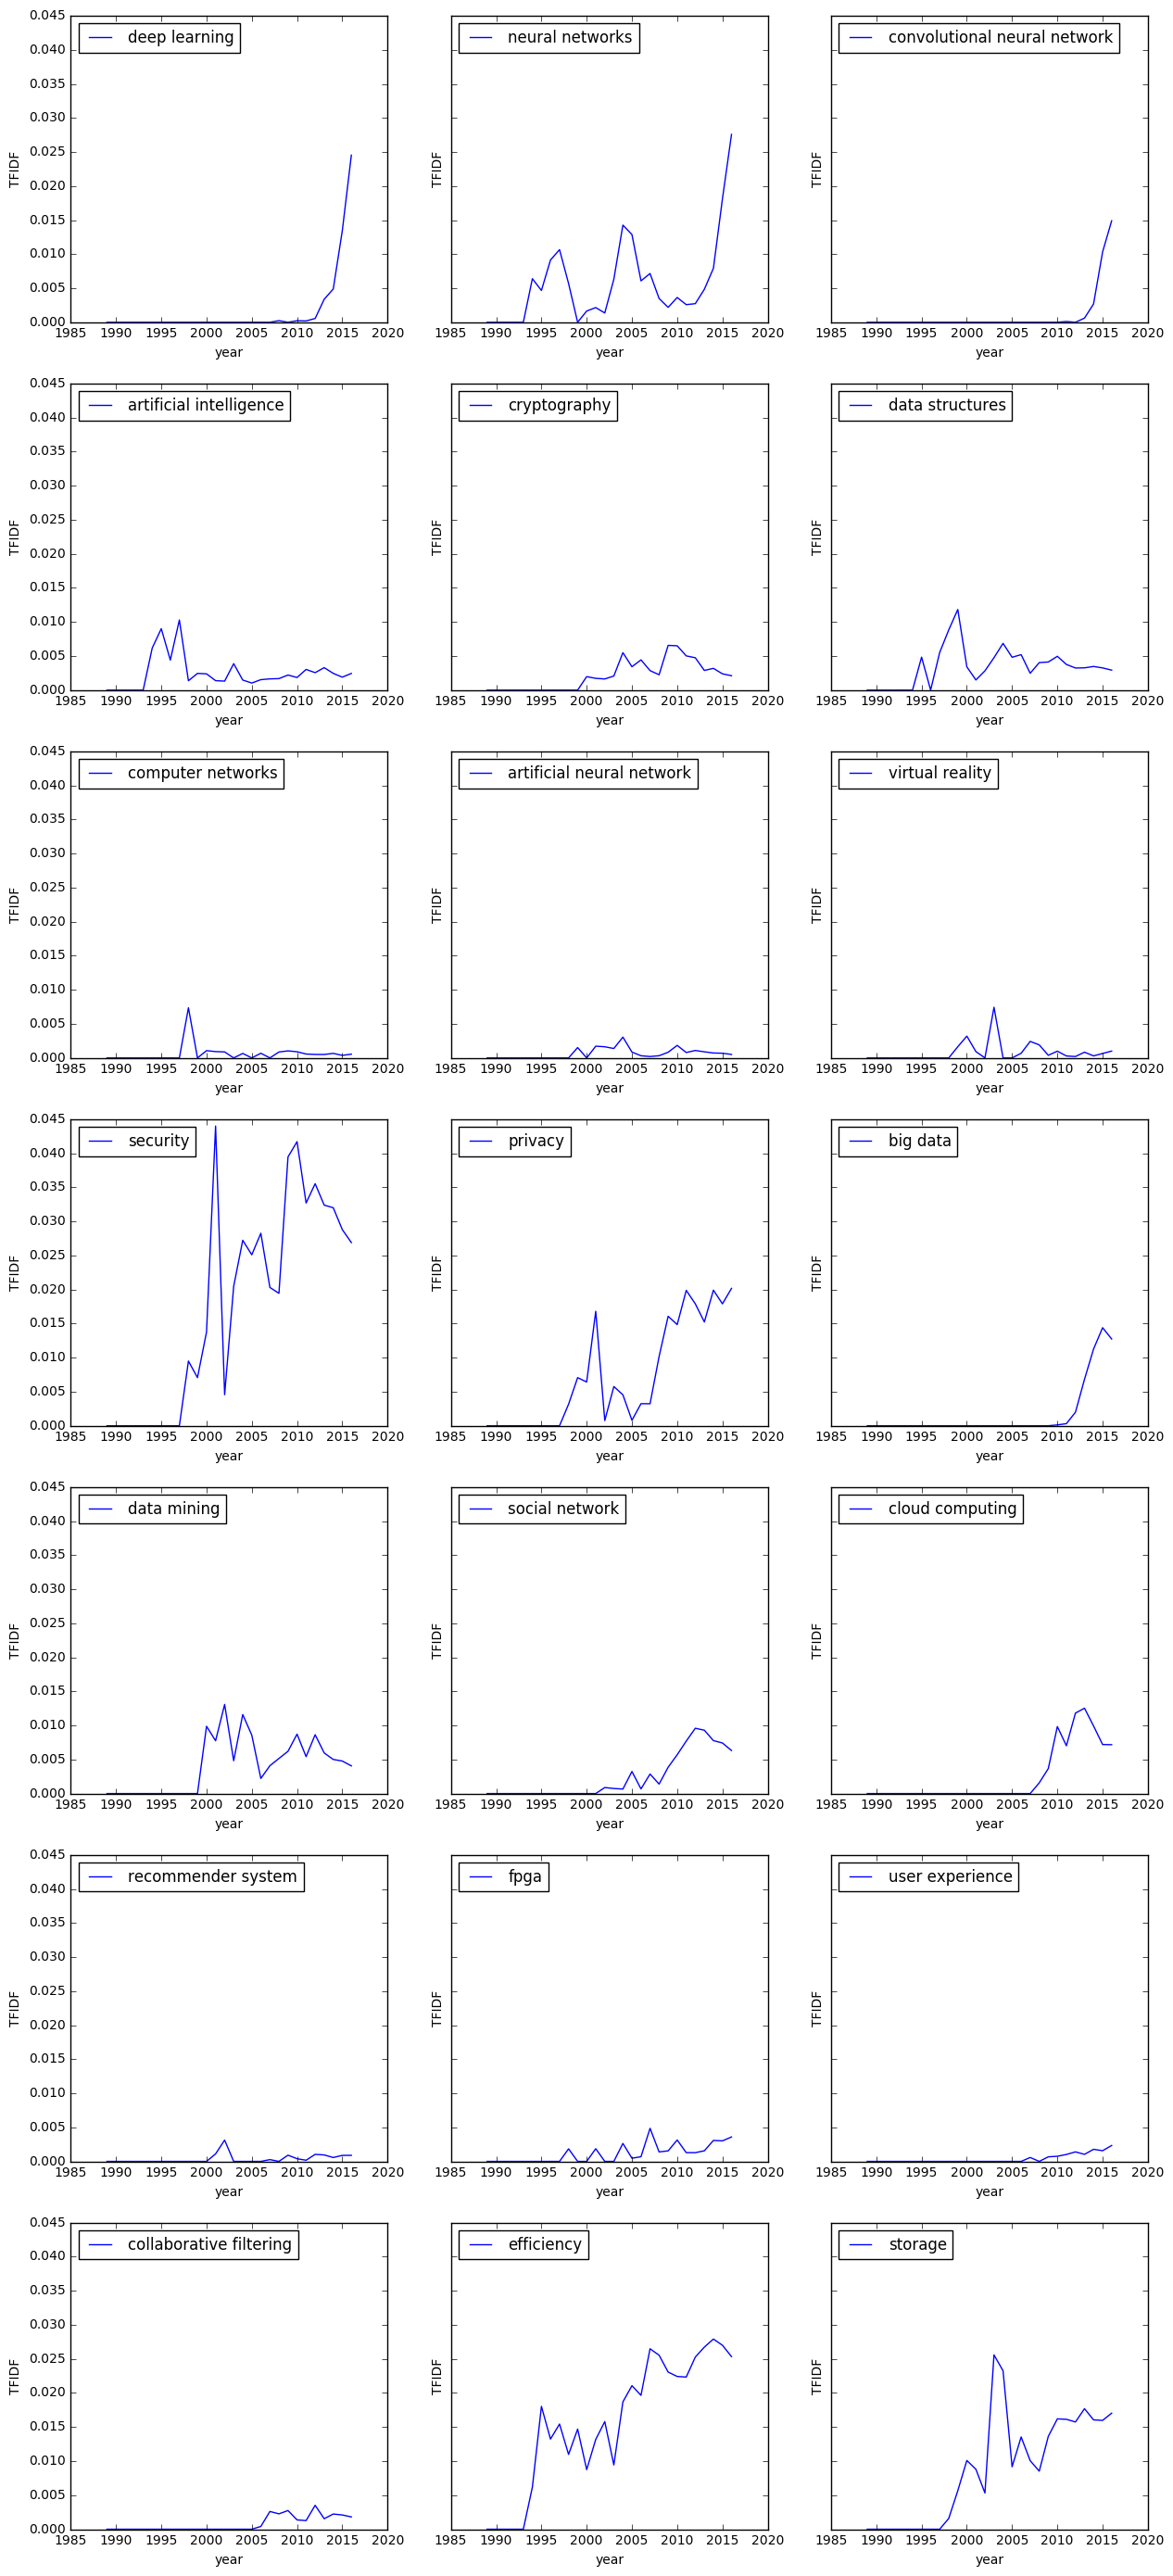

In [63]:
def plot_tfidf_field_trends(fields, abstract_features, abstractTfidf):
    '''
    Plots trends of TFIDF's of given fields
    '''
    field_idxs = [abstract_features.index(field) for field in fields]

    y_arr = [abstractTfidf.getcol(field_idx).todense().tolist() for field_idx in field_idxs]
    x = years_list

    m,n = int(math.ceil(len(fields)/float(3))), 3

    ax = []
    fig, axarr = plt.subplots(m,n, sharey=True, figsize=(n*5,m*5))
    for i in xrange(0, m):
        for j in xrange(0, n):
            if ((n*i) + j) < len(fields):
                axarr[i,j].plot(x, y_arr[i*n + j], label=fields[i*n + j])
                axarr[i,j].legend(loc='upper left')
                axarr[i,j].set_xlabel('year')
                axarr[i,j].set_ylabel('TFIDF')

    plt.show()
    
fields = ['deep learning', 'neural networks', 'convolutional neural network', 'artificial intelligence', 'cryptography', 'data structures', 'computer networks', 'artificial neural network', 'virtual reality', 'security', 'privacy', 'big data', 'data mining', 'social network', 'cloud computing', 'recommender system', 'fpga', 'user experience', 'collaborative filtering','efficiency', 'storage']
plot_tfidf_field_trends(fields, abstract_features, abstractTfidf)

- In the 1990’s, Yann Le Cunn introduced the world to the idea of a Neural Network. He released the now famous MNIST database in 1997. However, this was followed by a period of stagnation, where scientists were unable to make major breakthroughs in this area for nearly a decade. where it could not be applied to many other domains. However, with the Advent of GPU’s in the earlier part of this decade, there has been a resurgence in Deep Learning research [2].
- Similarly, FPGAs are slowly gaining importance due to better performance, and energy efficiency as compared to alternative forms of computing.
- Privacy and Security show similar trends. In today's world of increasing fear for personal information and data, we can see a growth in security research.
- We can see peaks in 'social networking' research around the time when Facebook and Twitter revolutionalized this field.

Other interesting results can be seen from the graphs above. Similarly, more such graphs can be generated by specifying keywords in the script above.

<h2>N_GRAM ON DATA SET</h2>

As a fun experiment, we develop an N-gram model for the arXiv data and build an abstract generative system that predicts an abstract for a given research field. Since the dataset is vast and consists of 680MB worth of files, we do this topic wise by extracting data from certain sub-categories such as "Computer Science", "Physics", "Mathematics", etc. We start by loading our data from the files. We call the python script 'pdngram' which calls our "Language Model" class. It builds our dictionary of n-grams and its count and returns the n-gram of a specified length. Before this we have to preprocess our data to put in the format as required by the class.

In [7]:
###### Code referenced from HW3 reference solutions ######
"""
Here,we Intialiaze by defining the relative paths to the folders containing the Research publications sorted by date.
For our Demonstration,We have Selected the Publications relevant to Physics,Computer Science,Mathematics and 
NOTE:THESE SCRIPTS RUN ON THE "DATA" FOlder which has not been submitted with this attachment.A Link to this Folder has
been attached above.Download the Folder,and store it in this Directory before rerunning this File.
"""
path1='./data /physics'
path2='./data /cs'
path3='./data /math'
path4='./data /stat'

listp=extractp(path1)    
print "\nN-Gram for Physics Research Paper Publications:"
our_ngram=LanguageModel(listp[:800],3)
print our_ngram.sample(200)
listp=extractp(path2)    
print "\nN-Gram for Computer Science Research Publications:"
our_ngram=LanguageModel(listp[:800],3)
print our_ngram.sample(200)
listp=extractp(path3)    
print "\nN-Gram for Mathematics Research Publications:"
our_ngram=LanguageModel(listp[:800],3)
print our_ngram.sample(200)
listp=extractp(path4)    
print "\nN-Gram for Statistics Research Publications:"
our_ngram=LanguageModel(listp[:800],3)
print our_ngram.sample(200)


N-Gram for Physics Research Paper Publications:
described . Energy values for the random phase approximation ( LDA ) , as can be related in a channel . The scaling exponents are indistinguishable from each other . A single narrow self-focused current jet of energetic electrons is used as atomic optical frequency standards which admits to introduce the notion of self potential is essential for tasks with , or when estimates of wire fixation and elimination of transverse components of high order mesh refinement multigrid computations is comparable to the usual sense but rather to insufficiencies in the sense of polarization dynamics in a storage ring with parameters such that b=Lx+e where e is a stable mode excited by a case of strongly overlapping RBS peaks a depth profile reconstruction without noise fitting has been used to calculate the time-dependent spectra of tetrahedral molecules The time-dependent local-density approximation ( TDLDA ) is examined by actual Monte Carlo simulatio

Although sentence structures are coherent and representative of the different fields, they would not make a lot of sense to a researcher. This was only a fun experiment and better results can be generated with more data.

### Conclusions

We notice that a lot of CS publication abstracts mention the words 'algorithms' and 'performance'. This tells us that a lot of research is focussed on better computing performance and faster algorithms. Researchers are constantly looking at better algorithms to increase speed, performance, energy efficiency, etc. 
Similarly we constantly see words like 'learning', 'intelligence', 'feature', etc showing a growing trend in intelligent systems and machine learning.

The time graphs show us interesting trends in certain specific fields of research as described above. Fields like 'security', 'learning' and 'storage' are on the rise.

### Future Work

- Combining Patent and publication data to get better and more accurate results.
- Finding hot spots of research to analyze and predict which universities, companies or nations are likely to publish and contribute to research in the future.
- Predict the future trends in research based on current trends.
- Predict inter and cross-disciplinary research from current research trends.

### References

- [1] A. Hoonlor, B. K. Szymanski, and M. J. Zaki. Trends in computer science research. Communications
of the ACM, 56(10):74–83, Oct. 2013. doi> 10.1145/2500892/
- [2] https://www.technologyreview.com/s/540001/teaching-machines-to-understand-us/